In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install unidecode
!pip install tqdm

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128,expandable_segments:True"
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from unidecode import unidecode
from tqdm import tqdm

In [ ]:
# Defines base directory and data folders
BASE_DIR = r"/content/drive/MyDrive/APS360_Project"
TRAIN_TENSOR_FOLDER = os.path.join(BASE_DIR, "combined_tensors_train")
VAL_TENSOR_FOLDER   = os.path.join(BASE_DIR, "combined_tensors_val")
TEST_TENSOR_FOLDER  = os.path.join(BASE_DIR, "combined_tensors_test")

!cp "/content/drive/MyDrive/APS360_Project/final_train_metadata.csv" /tmp/
!cp "/content/drive/MyDrive/APS360_Project/final_val_metadata.csv" /tmp/
!cp "/content/drive/MyDrive/APS360_Project/final_test_metadata.csv" /tmp/

TRAIN_METADATA = "/tmp/final_train_metadata.csv"
VAL_METADATA   = "/tmp/final_val_metadata.csv"
TEST_METADATA  = "/tmp/final_test_metadata.csv"
CHECKPOINT_DIR = BASE_DIR

INPUT_SIZE  = 39
OUTPUT_SIZE = 11
BATCH_SIZE  = 4
PATIENCE    = 3
DEBUG = False


In [ ]:
# Collate function to process a batch of data
def collate(batch):
    if DEBUG:
        print("[collate] Received a batch of size:", len(batch))

    # Separate tensors and labels, convert tensors to float and ensure they are contiguous
    tensors, labels = zip(*batch)
    tensors = [tensor.float().contiguous() for tensor in tensors]

    # Pad tensors to the same length and stack labels into a tensor
    padded_tensors = pad_sequence(tensors, batch_first=True, padding_value=0)
    labels = torch.stack(labels, dim=0)

    # Get original sequence lengths and pack the padded tensors
    sequence_lengths = torch.tensor([len(tensor) for tensor in tensors], dtype=torch.long)
    if DEBUG:
        print("[collate] Padded tensors shape:", padded_tensors.shape)
        print("[collate] Sequence lengths:", sequence_lengths.tolist())
    packed_input = pack_padded_sequence(
        padded_tensors,
        sequence_lengths,
        batch_first=True,
        enforce_sorted=False
    )

    # Ensure the packed data is contiguous
    if not packed_input.data.is_contiguous():
        packed_input = torch.nn.utils.rnn.PackedSequence(
            packed_input.data.contiguous(),
            packed_input.batch_sizes,
            packed_input.sorted_indices,
            packed_input.unsorted_indices
        )

    if DEBUG:
        print("[collate] Returning packed_input and labels.\n")
    return packed_input, labels


In [ ]:
class TensorDataset(Dataset):
    def __init__(self, tensor_folder, metadata_csv):
        # Initialize dataset (load metadata and list tensor files.)
        if DEBUG:
            print(f"\n[TensorDataset] Initializing dataset for folder: {tensor_folder}")
        self.tensor_folder = tensor_folder

        if DEBUG:
            print(f"[TensorDataset] Reading metadata from {metadata_csv}")
        self.df = pd.read_csv(metadata_csv)
        self.df[self.df.columns[0]] = self.df[self.df.columns[0]].apply(unidecode)
        self.file_list = os.listdir(tensor_folder)
        if DEBUG:
            print(f"[TensorDataset] Found {len(self.file_list)} files on disk.")
        self.matching_df = self.df[self.df[self.df.columns[0]].isin(self.file_list)].copy()
        self.matching_df.sort_values(by=self.matching_df.columns[0], inplace=True)
        self.labels = self.matching_df.iloc[:, 1:].values
        self.filenames = self.matching_df[self.df.columns[0]].tolist()
        if DEBUG:
            print(f"[TensorDataset] Dataset initialization complete. Total items: {len(self.filenames)}\n")

    def _rename_files(self):
        # Rename files to normalized names.
        fails = []
        for file in os.listdir(self.tensor_folder):
            normalized_name = unidecode(file)
            if file != normalized_name:
                old_file_path = os.path.join(self.tensor_folder, file)
                new_file_path = os.path.join(self.tensor_folder, normalized_name)
                if os.path.exists(old_file_path):
                    try:
                        os.rename(old_file_path, new_file_path)
                        if DEBUG:
                            print(f"[TensorDataset] Renamed: {file} -> {normalized_name}")
                    except Exception as e:
                        if DEBUG:
                            print(f"[TensorDataset] Error renaming {file}: {e}")
                        fails.append((file, str(e)))
                else:
                    if DEBUG:
                        print(f"[TensorDataset] File not found, skipping: {file}")
                    fails.append((file, "File not found"))
        if fails and DEBUG:
            print("\n[TensorDataset] Failed renames in folder:", self.tensor_folder)
            for f in fails:
                print(f"  - {f}")

    def __len__(self):
        # Return total number of items in the dataset.
        return len(self.filenames)

    def __getitem__(self, idx):
        # Load and return the tensor and corresponding label for the given index.
        fname = self.filenames[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        tensor_path = os.path.join(self.tensor_folder, fname)
        data_array = np.load(tensor_path, mmap_mode='r')
        tensor = torch.tensor(data_array, dtype=torch.float32).contiguous()
        if tensor.shape[0] > MAX_SEQ_LEN:
            tensor = tensor[:MAX_SEQ_LEN, :]
        if DEBUG and idx % 50 == 0:
            print(f"[TensorDataset] Loading item {idx}: {fname} with shape {tensor.shape}")
        return tensor, label

def create_data_loader(tensor_folder, metadata_csv, batch_size=BATCH_SIZE, shuffle=False):
    # Create and return a DataLoader for the TensorDataset.
    if DEBUG:
        print(f"\n[create_data_loader] Creating DataLoader for folder: {tensor_folder}")
    dataset = TensorDataset(tensor_folder, metadata_csv)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=4,
        pin_memory=True,
        collate_fn=collate
    )
    if DEBUG:
        print(f"[create_data_loader] DataLoader created with {len(dataset)} samples and batch_size={batch_size}.\n")
    return loader


In [ ]:
class MusicGRU(nn.Module):
    def __init__(self, input_size, hidden_size=256, output_size=OUTPUT_SIZE, num_layers=5, dropout=0.3):
        super(MusicGRU, self).__init__()
        if DEBUG:
            print(f"[MusicGRU] Initializing MusicGRU with input_size={input_size}, hidden_size={hidden_size}, "
                  f"output_size={output_size}, num_layers={num_layers}, dropout={dropout}.")
        # Initialize GRU, normalization, and output layers
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        if DEBUG:
            print("[MusicGRU.forward] Forward pass started.")
        # Processes input as a PackedSequence if this part is required
        if isinstance(x, torch.nn.utils.rnn.PackedSequence):
            if not x.data.is_contiguous():
                if DEBUG:
                    print("[MusicGRU.forward] Making PackedSequence data contiguous.")
                x = torch.nn.utils.rnn.PackedSequence(
                    x.data.contiguous(),
                    x.batch_sizes,
                    x.sorted_indices,
                    x.unsorted_indices
                )
            self.gru.flatten_parameters()
            try:
                _, hidden = self.gru(x)
            except RuntimeError as e:
                if DEBUG:
                    print("RuntimeError in GRU with PackedSequence. Disabling cuDNN for this call.")
                with torch.backends.cudnn.flags(enabled=False):
                    _, hidden = self.gru(x)
            out = hidden[-1]
        else:
            if DEBUG:
                print("[MusicGRU.forward] Input is not a PackedSequence.")
            if not x.is_contiguous():
                if DEBUG:
                    print("[MusicGRU.forward] Making tensor data contiguous.")
                x = x.contiguous()
            x = x.float()
            self.gru.flatten_parameters()
            device = x.device
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
            try:
                out, _ = self.gru(x, h0)
            except RuntimeError as e:
                if DEBUG:
                    print("RuntimeError in GRU with non-packed input. Disabling cuDNN for this call.")
                with torch.backends.cudnn.flags(enabled=False):
                    out, _ = self.gru(x, h0)
            out = out[:, -1, :]
        # Normalize and apply final linear transformation
        out = self.layer_norm(out)
        out = self.fc(out)
        if DEBUG:
            print("[MusicGRU.forward] Forward pass complete.\n")
        return out


In [ ]:
# Training & Evaluation Functions (with Early Stopping)

def train_and_evaluate_model(model, train_loader, val_loader, num_epochs=15, learning_rate=0.001, patience=3):
    # Setup device, loss, optimizer, and mixed-precision scaler
    print("[train_and_evaluate_model] Starting training...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[train_and_evaluate_model] Using device: {device}")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scaler = torch.cuda.amp.GradScaler()

    # Load checkpoint if available
    if os.path.exists(CHECKPOINT_PATH):
        print(f"[train_and_evaluate_model] Loading checkpoint from {CHECKPOINT_PATH}...")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        print(f"[train_and_evaluate_model] Checkpoint loaded! Resuming from epoch {start_epoch} with best_val_loss = {best_val_loss:.4f}\n")
    else:
        start_epoch = 0
        best_val_loss = float('inf')
        print("[train_and_evaluate_model] No checkpoint found. Starting training from scratch.\n")

    train_losses, val_losses = [], []
    training_start_time = time.time()
    last_time_log = training_start_time
    wait = 0  # Early stopping counter

    for epoch in range(start_epoch, num_epochs):
        print(f"\n[train_and_evaluate_model] Epoch {epoch+1}/{num_epochs} - Training Phase")
        model.train()
        total_train_loss = 0

        for batch_idx, (songs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Training")):
            current_time = time.time()
            if current_time - last_time_log >= 300:
                elapsed = current_time - training_start_time
                print(f"[train_and_evaluate_model] Time elapsed so far: {elapsed/60:.2f} minutes")
                last_time_log = current_time

            songs, labels = songs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(songs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"[train_and_evaluate_model] Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}")

        print(f"[train_and_evaluate_model] Epoch {epoch+1}/{num_epochs} - Validation Phase")
        model.eval()
        total_val_loss = 0
        for batch_idx, (songs, labels) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch+1} Validation")):
            songs, labels = songs.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(songs)
                loss = criterion(outputs, labels)
            total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"[train_and_evaluate_model] Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")

        # Save checkpoint if validation improves; else, update early stopping counter
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            wait = 0
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }
            torch.save(checkpoint, CHECKPOINT_PATH)
            print(f"[train_and_evaluate_model] New best model found! Saving checkpoint at epoch {epoch+1}")
        else:
            wait += 1
            print(f"[train_and_evaluate_model] No improvement in validation loss at epoch {epoch+1}. Wait count: {wait}/{patience}")
            if wait >= patience:
                print("[train_and_evaluate_model] Early stopping triggered!")
                break

        torch.cuda.empty_cache()

    # Plot training and validation loss curves
    print("\n[train_and_evaluate_model] Training complete. Plotting loss curves...")
    plt.figure()
    epochs = list(range(start_epoch + 1, start_epoch + 1 + len(train_losses)))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    print("[train_and_evaluate_model] Training and evaluation finished.\n")


def test_model(model, test_loader):
    # Load the best checkpoint and evaluate model performance on test data
    print("[test_model] Starting testing...")
    from sklearn.metrics import mean_squared_error
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[test_model] Loading model weights from {CHECKPOINT_PATH}")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    predictions, ground_truths = [], []
    for batch_idx, (songs, labels) in enumerate(tqdm(test_loader, desc="Testing")):
        songs, labels = songs.to(device), labels.to(device)
        with torch.cuda.amp.autocast(dtype=torch.float16):
            outputs = model(songs)
        predictions.append(outputs.detach().cpu())
        ground_truths.append(labels.detach().cpu())
    predictions = torch.cat(predictions, dim=0).numpy()
    ground_truths = torch.cat(ground_truths, dim=0).numpy()
    mse = mean_squared_error(ground_truths, predictions)
    print(f"[test_model] Test MSE: {mse:.4f}\n")
    return predictions, ground_truths, mse


In [ ]:
# Hyperparameter Tuning Experiments
def run_experiment(exp_id, hidden_size, learning_rate, dropout):
    print(f"\n[Experiment {exp_id}] Starting experiment with hidden_size={hidden_size}, learning_rate={learning_rate}, dropout={dropout}")

    # Update checkpoint path per experiment to avoid conflicts
    exp_checkpoint = os.path.join(CHECKPOINT_DIR, f"BestModelCheckpoint_exp{exp_id}.pth")

    # Create DataLoaders
    train_loader = create_data_loader(TRAIN_TENSOR_FOLDER, TRAIN_METADATA, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = create_data_loader(VAL_TENSOR_FOLDER, VAL_METADATA, batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = create_data_loader(TEST_TENSOR_FOLDER, TEST_METADATA, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize the model with given hyperparameters
    model = MusicGRU(input_size=INPUT_SIZE, hidden_size=hidden_size, output_size=OUTPUT_SIZE, num_layers=5, dropout=dropout)

    # Set the global CHECKPOINT_PATH for this experiment
    global CHECKPOINT_PATH
    CHECKPOINT_PATH = exp_checkpoint

    # Train and evaluate the model
    train_and_evaluate_model(model, train_loader, val_loader, num_epochs=15, learning_rate=learning_rate, patience=PATIENCE)

    # Test the model and return the test MSE
    _, _, mse = test_model(model, test_loader)
    print(f"[Experiment {exp_id}] Completed with Test MSE: {mse:.4f}\n")
    return mse




=================== Starting Experiment 1 ===================

[Experiment 1] Starting experiment with hidden_size=256, learning_rate=0.001, dropout=0.3
[Experiment 1] Creating DataLoaders...
[Experiment 1] Initializing MusicGRU model...
[Experiment 1] Checkpoint path set to: /content/drive/MyDrive/APS360_Project/BestModelCheckpoint_exp1.pth
[Experiment 1] Starting training...
[train_and_evaluate_model] Starting training...
[train_and_evaluate_model] Using device: cuda
[train_and_evaluate_model] Loading checkpoint from /content/drive/MyDrive/APS360_Project/BestModelCheckpoint_exp1.pth...


<ipython-input-8-f72e8cf03e10>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


[train_and_evaluate_model] Checkpoint loaded! Resuming from epoch 4 with best_val_loss = 93.2796


[train_and_evaluate_model] Epoch 5/15 - Training Phase


Epoch 5 Training:   0%|          | 0/1535 [00:00<?, ?it/s]<ipython-input-8-f72e8cf03e10>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 Training:  92%|█████████▏| 1405/1535 [05:01<01:51,  1.16it/s]

[train_and_evaluate_model] Time elapsed so far: 5.02 minutes


Epoch 5 Training: 100%|██████████| 1535/1535 [05:43<00:00,  4.47it/s]


[train_and_evaluate_model] Epoch 5 - Training Loss: 93.7029
[train_and_evaluate_model] Epoch 5/15 - Validation Phase


Epoch 5 Validation:   0%|          | 0/371 [00:00<?, ?it/s]<ipython-input-8-f72e8cf03e10>:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 Validation: 100%|██████████| 371/371 [02:06<00:00,  2.92it/s]


[train_and_evaluate_model] Epoch 5 - Validation Loss: 93.2762
[train_and_evaluate_model] New best model found! Saving checkpoint at epoch 5

[train_and_evaluate_model] Epoch 6/15 - Training Phase


Epoch 6 Training:  41%|████      | 632/1535 [02:09<05:23,  2.79it/s]

[train_and_evaluate_model] Time elapsed so far: 10.02 minutes


Epoch 6 Training:  98%|█████████▊| 1509/1535 [07:09<00:13,  1.94it/s]

[train_and_evaluate_model] Time elapsed so far: 15.02 minutes


Epoch 6 Training: 100%|██████████| 1535/1535 [07:19<00:00,  3.50it/s]


[train_and_evaluate_model] Epoch 6 - Training Loss: 93.5753
[train_and_evaluate_model] Epoch 6/15 - Validation Phase


Epoch 6 Validation: 100%|██████████| 371/371 [01:58<00:00,  3.13it/s]


[train_and_evaluate_model] Epoch 6 - Validation Loss: 94.6567
[train_and_evaluate_model] No improvement in validation loss at epoch 6. Wait count: 1/3

[train_and_evaluate_model] Epoch 7/15 - Training Phase


Epoch 7 Training:  53%|█████▎    | 813/1535 [02:52<06:37,  1.82it/s]

[train_and_evaluate_model] Time elapsed so far: 20.04 minutes


Epoch 7 Training: 100%|██████████| 1535/1535 [06:32<00:00,  3.91it/s]


[train_and_evaluate_model] Epoch 7 - Training Loss: 93.7465
[train_and_evaluate_model] Epoch 7/15 - Validation Phase


Epoch 7 Validation: 100%|██████████| 371/371 [01:48<00:00,  3.43it/s]


[train_and_evaluate_model] Epoch 7 - Validation Loss: 93.5616
[train_and_evaluate_model] No improvement in validation loss at epoch 7. Wait count: 2/3

[train_and_evaluate_model] Epoch 8/15 - Training Phase


Epoch 8 Training:   0%|          | 1/1535 [00:00<10:36,  2.41it/s]

[train_and_evaluate_model] Time elapsed so far: 25.51 minutes


Epoch 8 Training:  80%|████████  | 1231/1535 [05:02<06:52,  1.36s/it]

[train_and_evaluate_model] Time elapsed so far: 30.54 minutes


Epoch 8 Training: 100%|██████████| 1535/1535 [06:35<00:00,  3.89it/s]


[train_and_evaluate_model] Epoch 8 - Training Loss: 93.5895
[train_and_evaluate_model] Epoch 8/15 - Validation Phase


Epoch 8 Validation: 100%|██████████| 371/371 [01:45<00:00,  3.50it/s]


[train_and_evaluate_model] Epoch 8 - Validation Loss: 94.1837
[train_and_evaluate_model] No improvement in validation loss at epoch 8. Wait count: 3/3
[train_and_evaluate_model] Early stopping triggered!

[train_and_evaluate_model] Training complete. Plotting loss curves...


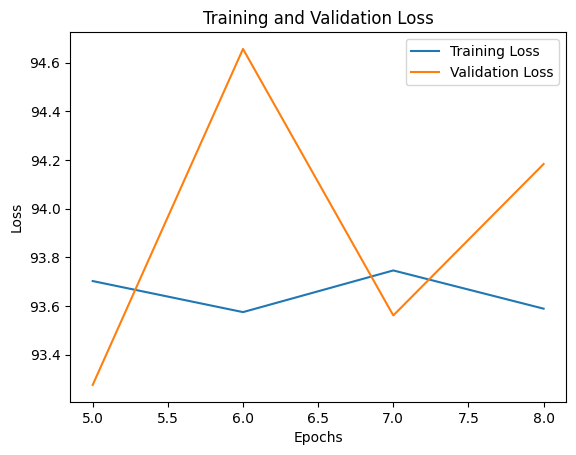

[train_and_evaluate_model] Training and evaluation finished.

[Experiment 1] Training complete. Now testing the model...
[test_model] Starting testing...
[test_model] Loading model weights from /content/drive/MyDrive/APS360_Project/BestModelCheckpoint_exp1.pth


Testing:   0%|          | 0/366 [00:00<?, ?it/s]<ipython-input-8-f72e8cf03e10>:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):
Testing: 100%|██████████| 366/366 [02:05<00:00,  2.92it/s]


[test_model] Test MSE: 90.1523

[Experiment 1] Completed with Test MSE: 90.1523

=================== Finished Experiment 1 ===================


=================== Starting Experiment 2 ===================

[Experiment 2] Starting experiment with hidden_size=512, learning_rate=0.0005, dropout=0.3
[Experiment 2] Creating DataLoaders...
[Experiment 2] Initializing MusicGRU model...
[Experiment 2] Checkpoint path set to: /content/drive/MyDrive/APS360_Project/BestModelCheckpoint_exp2.pth
[Experiment 2] Starting training...
[train_and_evaluate_model] Starting training...
[train_and_evaluate_model] Using device: cuda
[train_and_evaluate_model] Loading checkpoint from /content/drive/MyDrive/APS360_Project/BestModelCheckpoint_exp2.pth...


<ipython-input-8-f72e8cf03e10>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


[train_and_evaluate_model] Checkpoint loaded! Resuming from epoch 1 with best_val_loss = 93.2184


[train_and_evaluate_model] Epoch 2/15 - Training Phase


Epoch 2 Training:   0%|          | 0/1535 [00:00<?, ?it/s]<ipython-input-8-f72e8cf03e10>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 Training:   2%|▏         | 30/1535 [05:51<43:11:33, 103.32s/it]

[train_and_evaluate_model] Time elapsed so far: 5.86 minutes


Epoch 2 Training: 100%|██████████| 1535/1535 [10:43<00:00,  2.38it/s]


[train_and_evaluate_model] Epoch 2 - Training Loss: 93.4908
[train_and_evaluate_model] Epoch 2/15 - Validation Phase


Epoch 2 Validation:   0%|          | 0/371 [00:00<?, ?it/s]<ipython-input-8-f72e8cf03e10>:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 Validation: 100%|██████████| 371/371 [01:52<00:00,  3.30it/s]


[train_and_evaluate_model] Epoch 2 - Validation Loss: 93.3061
[train_and_evaluate_model] No improvement in validation loss at epoch 2. Wait count: 1/3

[train_and_evaluate_model] Epoch 3/15 - Training Phase


Epoch 3 Training:   0%|          | 1/1535 [00:00<24:29,  1.04it/s]

[train_and_evaluate_model] Time elapsed so far: 12.62 minutes


Epoch 3 Training:  84%|████████▎ | 1285/1535 [05:01<00:47,  5.24it/s]

[train_and_evaluate_model] Time elapsed so far: 17.62 minutes


Epoch 3 Training: 100%|██████████| 1535/1535 [06:14<00:00,  4.10it/s]


[train_and_evaluate_model] Epoch 3 - Training Loss: 93.5429
[train_and_evaluate_model] Epoch 3/15 - Validation Phase


Epoch 3 Validation: 100%|██████████| 371/371 [01:42<00:00,  3.62it/s]


[train_and_evaluate_model] Epoch 3 - Validation Loss: 95.3739
[train_and_evaluate_model] No improvement in validation loss at epoch 3. Wait count: 2/3

[train_and_evaluate_model] Epoch 4/15 - Training Phase


Epoch 4 Training:  44%|████▍     | 678/1535 [02:04<03:36,  3.95it/s]

[train_and_evaluate_model] Time elapsed so far: 22.62 minutes


Epoch 4 Training: 100%|██████████| 1535/1535 [06:23<00:00,  4.01it/s]


[train_and_evaluate_model] Epoch 4 - Training Loss: 93.3698
[train_and_evaluate_model] Epoch 4/15 - Validation Phase


Epoch 4 Validation: 100%|██████████| 371/371 [01:46<00:00,  3.48it/s]


[train_and_evaluate_model] Epoch 4 - Validation Loss: 93.9399
[train_and_evaluate_model] No improvement in validation loss at epoch 4. Wait count: 3/3
[train_and_evaluate_model] Early stopping triggered!

[train_and_evaluate_model] Training complete. Plotting loss curves...


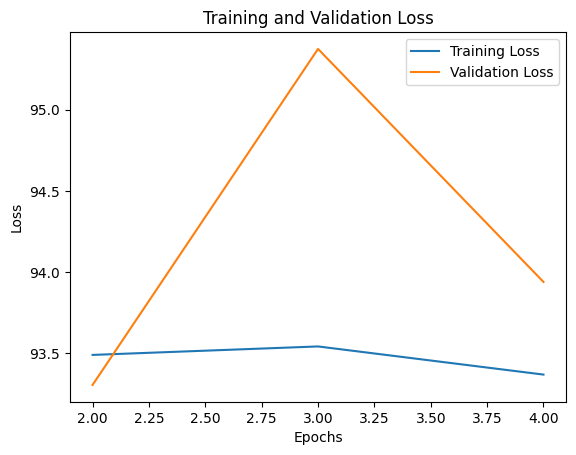

[train_and_evaluate_model] Training and evaluation finished.

[Experiment 2] Training complete. Now testing the model...
[test_model] Starting testing...
[test_model] Loading model weights from /content/drive/MyDrive/APS360_Project/BestModelCheckpoint_exp2.pth


Testing:   0%|          | 0/366 [00:00<?, ?it/s]<ipython-input-8-f72e8cf03e10>:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):
Testing: 100%|██████████| 366/366 [02:00<00:00,  3.05it/s]


[test_model] Test MSE: 90.1742

[Experiment 2] Completed with Test MSE: 90.1742

=================== Finished Experiment 2 ===================


=================== Starting Experiment 3 ===================

[Experiment 3] Starting experiment with hidden_size=256, learning_rate=0.001, dropout=0.5
[Experiment 3] Creating DataLoaders...
[Experiment 3] Initializing MusicGRU model...
[Experiment 3] Checkpoint path set to: /content/drive/MyDrive/APS360_Project/BestModelCheckpoint_exp3.pth
[Experiment 3] Starting training...
[train_and_evaluate_model] Starting training...
[train_and_evaluate_model] Using device: cuda
[train_and_evaluate_model] Loading checkpoint from /content/drive/MyDrive/APS360_Project/BestModelCheckpoint_exp3.pth...


<ipython-input-8-f72e8cf03e10>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


[train_and_evaluate_model] Checkpoint loaded! Resuming from epoch 6 with best_val_loss = 88.9591


[train_and_evaluate_model] Epoch 7/15 - Training Phase


Epoch 7 Training:   0%|          | 0/1535 [00:00<?, ?it/s]<ipython-input-8-f72e8cf03e10>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 Training:   2%|▏         | 27/1535 [06:01<44:40:08, 106.64s/it]

[train_and_evaluate_model] Time elapsed so far: 6.02 minutes


Epoch 7 Training:  97%|█████████▋| 1492/1535 [11:01<00:09,  4.62it/s]

[train_and_evaluate_model] Time elapsed so far: 11.02 minutes


Epoch 7 Training: 100%|██████████| 1535/1535 [11:12<00:00,  2.28it/s]


[train_and_evaluate_model] Epoch 7 - Training Loss: 89.3485
[train_and_evaluate_model] Epoch 7/15 - Validation Phase


Epoch 7 Validation:   0%|          | 0/371 [00:00<?, ?it/s]<ipython-input-8-f72e8cf03e10>:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 Validation: 100%|██████████| 371/371 [01:42<00:00,  3.61it/s]


[train_and_evaluate_model] Epoch 7 - Validation Loss: 88.9095
[train_and_evaluate_model] New best model found! Saving checkpoint at epoch 7

[train_and_evaluate_model] Epoch 8/15 - Training Phase


Epoch 8 Training:  58%|█████▊    | 886/1535 [03:05<03:43,  2.90it/s]

[train_and_evaluate_model] Time elapsed so far: 16.03 minutes


Epoch 8 Training: 100%|██████████| 1535/1535 [06:15<00:00,  4.08it/s]


[train_and_evaluate_model] Epoch 8 - Training Loss: 89.0077
[train_and_evaluate_model] Epoch 8/15 - Validation Phase


Epoch 8 Validation: 100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[train_and_evaluate_model] Epoch 8 - Validation Loss: 93.4070
[train_and_evaluate_model] No improvement in validation loss at epoch 8. Wait count: 1/3

[train_and_evaluate_model] Epoch 9/15 - Training Phase


Epoch 9 Training:   4%|▍         | 63/1535 [00:09<06:03,  4.05it/s]

[train_and_evaluate_model] Time elapsed so far: 21.04 minutes


Epoch 9 Training:  31%|███       | 478/1535 [16:09<35:44,  2.03s/it]


KeyboardInterrupt: 

In [ ]:
# Main Script

def run_experiment(exp_id, hidden_size, learning_rate, dropout):
    print(f"\n[Experiment {exp_id}] Starting experiment with hidden_size={hidden_size}, learning_rate={learning_rate}, dropout={dropout}")

    # Update checkpoint path per experiment to avoid conflicts
    exp_checkpoint = os.path.join(CHECKPOINT_DIR, f"BestModelCheckpoint_exp{exp_id}.pth")

    # Create DataLoaders (they already print progress if needed)
    print(f"[Experiment {exp_id}] Creating DataLoaders...")
    train_loader = create_data_loader(TRAIN_TENSOR_FOLDER, TRAIN_METADATA, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = create_data_loader(VAL_TENSOR_FOLDER, VAL_METADATA, batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = create_data_loader(TEST_TENSOR_FOLDER, TEST_METADATA, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize the model with given hyperparameters
    print(f"[Experiment {exp_id}] Initializing MusicGRU model...")
    model = MusicGRU(input_size=INPUT_SIZE, hidden_size=hidden_size, output_size=OUTPUT_SIZE, num_layers=5, dropout=dropout)

    # Set the global CHECKPOINT_PATH for this experiment
    global CHECKPOINT_PATH
    CHECKPOINT_PATH = exp_checkpoint
    print(f"[Experiment {exp_id}] Checkpoint path set to: {CHECKPOINT_PATH}")

    # Train and evaluate the model
    print(f"[Experiment {exp_id}] Starting training...")
    train_and_evaluate_model(model, train_loader, val_loader, num_epochs=15, learning_rate=learning_rate, patience=PATIENCE)

    # After training, plot the loss curves (already done inside train_and_evaluate_model)
    print(f"[Experiment {exp_id}] Training complete. Now testing the model...")

    # Test the model and return the test MSE
    _, _, mse = test_model(model, test_loader)
    print(f"[Experiment {exp_id}] Completed with Test MSE: {mse:.4f}\n")
    return mse

# Main script for hyperparameter tuning
if __name__ == "__main__":
    # Define a list of hyperparameter configurations
    hyperparams_list = [
        {"exp_id": 1, "hidden_size": 256, "learning_rate": 0.001, "dropout": 0.3},
        {"exp_id": 2, "hidden_size": 512, "learning_rate": 0.0005, "dropout": 0.3},
        {"exp_id": 3, "hidden_size": 256, "learning_rate": 0.001, "dropout": 0.5},
    ]

    results = {}
    for params in hyperparams_list:
        print(f"\n=================== Starting Experiment {params['exp_id']} ===================")
        mse = run_experiment(**params)
        results[params["exp_id"]] = mse
        print(f"=================== Finished Experiment {params['exp_id']} ===================\n")

    print("\n[Hyperparameter Tuning] Summary of experiments:")
    for exp_id, mse in results.items():
        print(f"Experiment {exp_id}: Test MSE = {mse:.4f}")
